In [2]:
import os
import logging
from typing import List, Tuple, Literal, Optional
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_neo4j.vectorstores.neo4j_vector import Neo4jVector
from langchain_neo4j.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_neo4j import Neo4jGraph
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers.string import StrOutputParser
from langchain_neo4j.chains.graph_qa.cypher import GraphCypherQAChain
from IPython.display import Image, display

from langgraph.graph import StateGraph, END, add_messages
from typing_extensions import TypedDict, Annotated
from langchain_core.tools import tool


In [3]:
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
neo4j_uri = os.environ.get("NEO4J_URI")
neo4j_username = os.environ.get("NEO4J_USERNAME")
neo4j_password = os.environ.get("NEO4J_PASSWORD")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-Agent CyKG" 
os.environ["LANGCHAIN_API_KEY"] = os.environ.get("LANGCHAIN_API_KEY", "")
os.environ["LANGCHAIN_ENDPOINT"] = os.environ.get("LANGCHAIN_ENDPOINT", "")

logging.basicConfig(
     level=logging.INFO,
     format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
     handlers=[
         logging.FileHandler('./log/multi_agent_cykg.log'),
         logging.StreamHandler()
     ]
)
logger = logging.getLogger(__name__)

In [4]:
graph = Neo4jGraph()
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
DEFAULT_MAX_ITERATIONS = 3
NEO4J_SCHEMA_RAW = graph.schema
NEO4J_SCHEMA_ESCAPED_FOR_PROMPT = NEO4J_SCHEMA_RAW.replace("{", "{{").replace("}", "}}")


In [5]:
class AgentState(TypedDict):
    question: str
    original_question: str
    is_relevant: bool
    hybrid_context: Optional[str]
    cypher_context: Optional[List[dict]]
    answer: Optional[str]
    cypher_query: Optional[str]
    error: Optional[str]
    messages: Annotated[list, add_messages]
    iteration_count: int
    max_iterations: int

In [6]:
vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    search_type="hybrid",
    node_label="Resource",
    text_node_properties=["ns1__description"],
    embedding_node_property="embedding"
)

2025-06-24 20:14:05,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [7]:
class Entities(BaseModel):
    """Identifying information about resources."""

    names: List[str] = Field(
        ...,
        description="All the tactics, techniques, or software entities that "
        "appear in the text",
    )
    
entity_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting attack techniques, tactics, malware, mitigations entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {question}",
        ),
    ]
)

entity_chain = entity_prompt | llm.with_structured_output(Entities) #Pokoknya buat entity extraction

In [8]:
def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~2 changed characters) to each word, then combines
    them using the AND operator. Useful for mapping entities from user questions
    to database values, and allows for some misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

def structured_retriever(question: str) -> str:
    """
    Collects the neighborhood of resources mentioned
    in the question
    """
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node, score
            
            MATCH (node)-[r]-(neighbor)
            WHERE node.ns1__title IS NOT NULL AND neighbor.ns1__title IS NOT NULL
            
            RETURN CASE
                WHEN startNode(r) = node 
                THEN node.ns1__title + ' - ' + type(r) + ' -> ' + neighbor.ns1__title
                ELSE neighbor.ns1__title + ' - ' + type(r) + ' -> ' + node.ns1__title
            END AS output
            LIMIT 50
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
    return result
# print(structured_retriever(query1))

In [9]:
def query_hybrid_search(question: str):
    """
    Query the graph and vector index using a hybrid approach for vector similarity search.
    Use this for questions that require finding similar concepts or descriptions,
    like "Show me techniques related to 'SQL Injection'".
    """
    print(f"--- Executing Hybrid Search for: {question} ---")
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question)]
    final_data = f"""Structured data:
{structured_data}
Unstructured data:
{"#Resource ". join(unstructured_data)}
    """
    return final_data

In [10]:
cypher_generation_template = """
You are an expert Neo4j Cypher translator who converts English to Cypher based on the Neo4j Schema provided, following the instructions below:
        1. Generate Cypher query compatible ONLY for Neo4j Version 5
        2. Do not use EXISTS, SIZE, HAVING keywords in the cypher. Use alias when using the WITH keyword
        3. Use only Nodes and relationships mentioned in the schema
        5. Never use relationships that are not mentioned in the given schema
        6. For all node labels and relationship types, add namespace prefix `ns0__` before the actual label or relationship type. E.g., `MATCH (n:ns0__NodeLabel)-[:ns0__RelationshipType]->(m:ns0__NodeLabel)`.
        7. Node properties with `created`, `description`, `identifier`, `modified`, `title` and `version`, add prefix `ns1__` instead. E.g., `MATCH (n:ns0__NodeLabel) RETURN n.ns1__title AS Title`.
        8. Always do a case-insensitive and fuzzy search for any properties related search. Eg: to search for a Tactic, use `toLower(Tactic.ns1__title) contains 'persistence'`.
        9. Always assign a meaningful name to every node and relationship in the MATCH clause
        10. Never return components not explicitly named in the MATCH clause.
        11. In the RETURN clause, include all named components (nodes, relationships, or properties) to ensure consistency and understanding.
        12. Always return all the nodes used in the MATCH clause to provide complete information to the user.
        13. When counting distinct items that come from an `OPTIONAL MATCH`, prefer to `collect()` them first and then use `size()` on the collected list to avoid warnings about null values. For example, instead of `count(DISTINCT optional_item)`, use `WITH main_node, collect(DISTINCT optional_item) AS items` and then in the `RETURN` clause use `size(items) AS itemCount`.
        14. To create unique pairs of nodes for comparison (e.g., for similarity calculations), use the `elementId()` function instead of the deprecated `id()` function. For example: `WHERE elementId(node1) < elementId(node2)`.
        15. use `toLower()` function to ensure case-insensitive comparisons for string properties.

Schema:
{schema}

Note: 
Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything other than
for you to construct a Cypher statement. Do not include any text except
the generated Cypher statement. Make sure the direction of the relationship is
correct in your queries. Make sure you alias both entities and relationships
properly. Do not run any queries that would add to or delete from
the database. Make sure to alias all statements that follow as with
statement

In Cypher, you can alias nodes and relationships, but not entire pattern matches using AS directly after a MATCH clause.If you want to alias entire patterns or results of more complex expressions, that should be done in the RETURN clause, not the MATCH clause.
If you want to include any specific properties from these nodes in your results, you can add them to your RETURN statement.

Examples : 

1. Which techniques are commonly used by at least 3 different threat groups?
MATCH (g:ns0__Group)-[:ns0__usesTechnique]->(t:ns0__Technique)
WITH t, count(g) as groupCount
WHERE groupCount >= 3
MATCH (g:ns0__Group)-[:ns0__usesTechnique]->(t)
RETURN t.ns1__title as CommonTechnique, t.ns1__identifier as TechniqueID, 
       groupCount as NumberOfGroups,
       collect(g.ns1__title) as Groups
ORDER BY groupCount DESC

2. Find tactical areas where we have the most significant defensive gaps by identifying tactics that have many techniques but few mitigations, and rank them by coverage percentage!

MATCH (tactic:ns0__Tactic)<-[:ns0__accomplishesTactic]-(technique:ns0__Technique)
WITH tactic, collect(technique) as techniques, count(technique) as techniqueCount
UNWIND techniques as technique
OPTIONAL MATCH (mitigation:ns0__Mitigation)-[:ns0__preventsTechnique]->(technique)
WITH tactic, techniqueCount, technique, count(mitigation) > 0 as hasMitigation

WITH tactic, techniqueCount, 
     sum(CASE WHEN hasMitigation THEN 1 ELSE 0 END) as mitigatedTechniques,
     collect(CASE WHEN NOT hasMitigation THEN technique.ns1__title ELSE NULL END) as unmitigatedTechniques

WITH tactic, techniqueCount, mitigatedTechniques,
     [x IN unmitigatedTechniques WHERE x IS NOT NULL] as filteredUnmitigatedTechniques,
     (toFloat(mitigatedTechniques) / techniqueCount * 100) as coveragePercentage

RETURN tactic.ns1__title as Tactic,
       tactic.ns1__identifier as TacticID,
       techniqueCount as TotalTechniques,
       mitigatedTechniques as MitigatedTechniques,
       techniqueCount - mitigatedTechniques as UnmitigatedTechniqueCount,
       toInteger(coveragePercentage) as CoveragePercentage,
       CASE 
         WHEN coveragePercentage < 30 THEN "CRITICAL" 
         WHEN coveragePercentage < 60 THEN "HIGH" 
         WHEN coveragePercentage < 80 THEN "MEDIUM"
         ELSE "LOW"
       END as RiskLevel,
       filteredUnmitigatedTechniques as UnmitigatedTechniques
ORDER BY coveragePercentage ASC, techniqueCount DESC


The question is:
{question}

"""

In [11]:
cyper_generation_prompt = PromptTemplate(
    template=cypher_generation_template,
    input_variables=["schema","question"]
)

In [12]:
qa_template = """
You are an assistant that takes the results from a Neo4j Cypher query and forms a human-readable response. The query results section contains the results of a Cypher query that was generated based on a user's natural language question. The provided information is authoritative; you must never question it or use your internal knowledge to alter it. Make the answer sound like a response to the question.
Final answer should be easily readable and structured.
Query Results:
{context}

Question: {question}
If the provided information is empty, respond by stating that you don't know the answer. Empty information is indicated by: []
If the information is not empty, you must provide an answer using the results. If the question involves a time duration, assume the query results are in units of days unless specified otherwise.
Never state that you lack sufficient information if data is present in the query results. Always utilize the data provided.
Helpful Answer:
"""

In [13]:
qa_generation_prompt = PromptTemplate(
    template=qa_template,
    input_variables=["context", "question"]
)

In [14]:
cypher_qa_chain = GraphCypherQAChain.from_llm(
    top_k=10,
    graph=graph,
    verbose=True,
    validate_cypher=True,
    return_intermediate_steps=True,
    cypher_prompt=cyper_generation_prompt,
    qa_prompt=qa_generation_prompt,
    qa_llm=ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
    cypher_llm=ChatOpenAI(model="gpt-4o", temperature=0),
    allow_dangerous_requests=True,
    use_function_response=True
)

def query_cypher(question: str) -> dict:
    """
    Generate and run a Cypher query against the graph database.
    Use this for complex questions requiring structured data, aggregations, or specific graph traversals
    Returns the query and the result context.
    """
    print(f"--- Executing Cypher Search for: {question} ---")
    response = cypher_qa_chain.invoke({"query": question})
    return {
        "query": response["intermediate_steps"][0]["query"],
        "context": response["intermediate_steps"][1]["context"]
    }

In [15]:
class GuardrailsOutput(BaseModel):
    decision: Literal["relevant", "irrelevant"] = Field(description="Is the question relevant to cybersecurity, MITRE ATT&CK, tactics, malware, or threat actors?")

guardrails_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a gatekeeper for a cybersecurity Q&A system. Your task is to determine if a user's question is related to cybersecurity topics like MITRE ATT&CK, attack techniques, malware, threat groups, or mitigations. Only allow relevant questions to pass."),
    ("human", "Question: {question}"),
])
guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)

def guardrails_node(state: AgentState):
    """Decides if the question is relevant."""
    logger.info("--- Executing Node: guardrails ---")
    question = state['question']
    result = guardrails_chain.invoke({"question": question})
    if result.decision == "irrelevant":
        logger.warning(f"Guardrails: Irrelevant question detected -> '{question}'")
        return {"is_relevant": False, "answer": "Sorry, I can only answer questions related to cybersecurity and MITRE ATT&CK."}
    else:
        logger.info("Guardrails: Question is relevant.")
        return {"is_relevant": True}

In [22]:
def hybrid_search_node(state: AgentState):
    """Calls the hybrid search tool and populates the state."""
    logger.info("--- Executing Node: hybrid_search ---")
    question = state['question']
    try:
        hybrid_context = query_hybrid_search(question)
        logger.info("Hybrid search completed successfully.")
        logger.info(f"Hybrid search context found:\n{hybrid_context}")
        return {"hybrid_context": hybrid_context}
    except Exception as e:
        logger.error(f"Hybrid search failed: {e}")
        return {"hybrid_context": f"Error during hybrid search: {e}"}


def cypher_query_node(state: AgentState):
    """Calls the cypher search tool and populates the state."""
    logger.info(f"--- Executing Node: cypher_agent (Attempt: {state.get('iteration_count', 1)}) ---")
    question = state['question']
    try:
        cypher_result = query_cypher(question)
        context = cypher_result.get("context", [])
        generated_query = cypher_result.get("query", "")

        if not context:
            logger.warning(f"Cypher agent: No results found for query: {generated_query}")
        else:
            logger.info(f"Cypher agent: Found context. Query: {generated_query}")

        return {
            "cypher_query": generated_query,
            "cypher_context": context
        }
    except Exception as e:
        logger.error(f"Cypher agent failed: {e}", exc_info=True)
        return {
            "error": f"Gagal menjalankan query Cypher: {e}",
            "cypher_context": [],
            "cypher_query": "Failed to generate Cypher query due to an error."
        }

In [23]:
class RephrasedQuestion(BaseModel):
    rephrased_question: str = Field(description="A rephrased, more specific version of the original question to improve Cypher query generation.")

reflection_prompt = ChatPromptTemplate.from_messages([
    ("system", f"""You are a query correction expert. A Cypher query returned no results.
Your task is to rephrase the user's question to be more specific and likely to succeed with the given Neo4j graph schema.
Analyze the failed query and the schema. For example, if the question was too broad, make it more specific. If it used terms not in the schema, suggest alternatives.
Do not just repeat the question. Provide a meaningful improvement.

Schema:
{NEO4J_SCHEMA_ESCAPED_FOR_PROMPT}"""),
    ("human", "Original Question: {original_question}\n\nFailed Cypher Query:\n{cypher_query}\n\nRephrase the question to improve the chances of getting a result."),
])
reflection_chain = reflection_prompt | llm.with_structured_output(RephrasedQuestion)

def reflection_node(state: AgentState):
    """Reflects on the failed query and rephrases the question."""
    logger.info("--- Executing Node: reflection ---")
    original_question = state['original_question']
    failed_query = state['cypher_query']
    
    rephrased_result = reflection_chain.invoke({
        "original_question": original_question,
        "cypher_query": failed_query
    })
    
    new_question = rephrased_result.rephrased_question
    iteration_count = state['iteration_count'] + 1
    logger.info(f"Reflection: Rephrasing question to: '{new_question}'. New attempt: {iteration_count}.")
    
    return {"question": new_question, "iteration_count": iteration_count}

In [24]:
synthesis_prompt = ChatPromptTemplate.from_template("""You are an expert cybersecurity assistant tasked with synthesizing information from multiple sources to answer a user's question.
Your job is to generate a comprehensive final answer. Follow these steps:
1.  Review the "Original Question" from the user.
2.  Review the "Context from Cypher Query," which is structured data retrieved from the knowledge graph.
3.  Review the "Context from Hybrid Search," which contains both structured relationships and unstructured text.
4.  Clearly present the key findings from each source. If a source provided no data, state that.
5.  Critically analyze how well the combined information answers the "Original Question." If the information is incomplete or doesn't fully address the user's query, explain the potential reasons (e.g., "The database contains information on Group A and Software B, but it did not find a direct relationship between them as requested.").
6.  Construct a final, well-structured answer that includes both the retrieved data and your analysis.

The provided context is authoritative. Do not add any information not present in the results.
If both contexts are empty after all attempts, state that you could not find an answer.

Original Question: {question}

Context from Cypher Query:
{cypher_context}

Context from Hybrid Search:
{hybrid_context}

Synthesized Answer:
""")
synthesis_chain = synthesis_prompt | llm | StrOutputParser()

def synthesize_node(state: AgentState):
    """Generates the final answer for the user based on all gathered context."""
    logger.info("--- Executing Node: synthesizer ---")
    
    # Check if there is any context at all to synthesize
    if not state.get('cypher_context') and not state.get('hybrid_context'):
        logger.warning("Synthesizer: No context found from any source after all attempts.")
        final_answer = "Sorry, I could not find any information related to your question after several attempts."
    else:
        logger.info("Synthesizer: Context found. Generating final synthesized answer.")
        final_answer = synthesis_chain.invoke({
            "question": state['original_question'],
            "cypher_context": str(state.get('cypher_context', 'No data was found from the structured query.')),
            "hybrid_context": str(state.get('hybrid_context', 'No data was found from the hybrid search.'))
        })
        
    return {"answer": final_answer}

In [25]:
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("guardrails", guardrails_node)
workflow.add_node("hybrid_search", hybrid_search_node)
workflow.add_node("cypher_agent", cypher_query_node)
workflow.add_node("reflection", reflection_node)
workflow.add_node("synthesizer", synthesize_node)

# Define Edges
workflow.set_entry_point("guardrails")

# 1. Guardrails -> Hybrid Search or End
def decide_relevance(state: AgentState):
    if state.get('is_relevant'):
        logger.info("Decision: Question is relevant, proceeding to Hybrid Search.")
        return "hybrid_search"
    else:
        logger.info("Decision: Question is irrelevant, ending execution.")
        return END

workflow.add_conditional_edges(
    "guardrails",
    decide_relevance,
    {
        "hybrid_search": "hybrid_search",
        END: END
    }
)

# 2. Hybrid Search -> Cypher Agent
workflow.add_edge("hybrid_search", "cypher_agent")

# 3. Cypher Agent -> Reflection or Synthesizer
def decide_after_cypher(state: AgentState):
    """Decides whether to synthesize an answer or reflect and retry."""
    if state.get("cypher_context"):
        logger.info("Decision: Cypher has context. Proceeding to synthesizer.")
        return "synthesizer"
    
    if state.get("iteration_count", 0) < state.get("max_iterations", 3):
        logger.warning("Decision: Cypher has no context. Proceeding to reflection.")
        return "reflection"
    else:
        logger.error("Decision: Max retries reached. Proceeding to synthesizer.")
        return "synthesizer"

workflow.add_conditional_edges(
    "cypher_agent",
    decide_after_cypher,
    {
        "synthesizer": "synthesizer",
        "reflection": "reflection"
    }
)

# 4. Reflection -> Cypher Agent
workflow.add_edge("reflection", "cypher_agent")

# 5. Synthesizer -> End
workflow.add_edge("synthesizer", END)

app = workflow.compile()

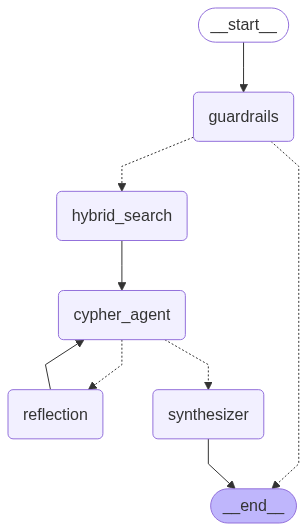

In [26]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not create graph visualization: {e}")

In [33]:
query = "Which MITRE ATT&CK techniques are used by attackers to escalate their privileges within a network?"
# query = "find me a list of mitigation actions for attack technique Credential Access"

# Query 3: Irrelevant question for Guardrails
# query = "What is the best recipe for fried chicken?"

initial_state = {
    "question": query,
    "original_question": query,
    "messages": [("human", query)],
    "iteration_count": 1,
    "max_iterations": 3,
}

config = {"recursion_limit": 10}
final_result = app.invoke(initial_state, config=config)


2025-06-24 20:56:21,809 - __main__ - INFO - --- Executing Node: guardrails ---
2025-06-24 20:56:23,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-24 20:56:23,232 - __main__ - INFO - Guardrails: Question is relevant.
2025-06-24 20:56:23,233 - __main__ - INFO - Decision: Question is relevant, proceeding to Hybrid Search.
2025-06-24 20:56:23,234 - __main__ - INFO - --- Executing Node: hybrid_search ---


--- Executing Hybrid Search for: Which MITRE ATT&CK techniques are used by attackers to escalate their privileges within a network? ---


2025-06-24 20:56:25,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-24 20:56:26,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-24 20:56:26,885 - __main__ - INFO - Hybrid search completed successfully.
2025-06-24 20:56:26,886 - __main__ - INFO - Hybrid search context found:
Structured data:
Privilege Escalation - ns0__hasTechnique -> Exploitation for Privilege Escalation
Privilege Escalation - ns0__hasTechnique -> Hooking
Exploitation for Privilege Escalation - ns0__accomplishesTactic -> Privilege Escalation
Hooking - ns0__accomplishesTactic -> Privilege Escalation
Exploitation for Privilege Escalation - ns0__hasMitigation -> Application Isolation and Sandboxing
Exploitation for Privilege Escalation - ns0__hasMitigation -> Update Software
Exploitation for Privilege Escalation - ns0__hasMitigation -> Threat Intelligence Program
Exploitation for Privilege Escalation - ns0__

--- Executing Cypher Search for: Which MITRE ATT&CK techniques are used by attackers to escalate their privileges within a network? ---


> Entering new GraphCypherQAChain chain...


2025-06-24 20:56:29,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated Cypher:
cypher
MATCH (technique:ns0__Technique)-[:ns0__accomplishesTactic]->(tactic:ns0__Tactic)
WHERE toLower(tactic.ns1__title) CONTAINS 'escalate privileges'
RETURN technique.ns1__title AS TechniqueTitle, 
       technique.ns1__identifier AS TechniqueID, 
       tactic.ns1__title AS TacticTitle

Full Context:
[]


2025-06-24 20:56:30,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-24 20:56:30,485 - __main__ - WARNING - Cypher agent: No results found for query: cypher
MATCH (technique:ns0__Technique)-[:ns0__accomplishesTactic]->(tactic:ns0__Tactic)
WHERE toLower(tactic.ns1__title) CONTAINS 'escalate privileges'
RETURN technique.ns1__title AS TechniqueTitle, 
       technique.ns1__identifier AS TechniqueID, 
       tactic.ns1__title AS TacticTitle

2025-06-24 20:56:30,486 - __main__ - WARNING - Decision: Cypher has no context. Proceeding to reflection.
2025-06-24 20:56:30,488 - __main__ - INFO - --- Executing Node: reflection ---



> Finished chain.


2025-06-24 20:56:33,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-24 20:56:33,137 - __main__ - INFO - Reflection: Rephrasing question to: 'What are the specific MITRE ATT&CK techniques associated with the 'Privilege Escalation' tactic?'. New attempt: 2.
2025-06-24 20:56:33,139 - __main__ - INFO - --- Executing Node: cypher_agent (Attempt: 2) ---


--- Executing Cypher Search for: What are the specific MITRE ATT&CK techniques associated with the 'Privilege Escalation' tactic? ---


> Entering new GraphCypherQAChain chain...


2025-06-24 20:56:36,354 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated Cypher:
cypher
MATCH (tactic:ns0__Tactic)
WHERE toLower(tactic.ns1__title) CONTAINS 'privilege escalation'
MATCH (technique:ns0__Technique)-[:ns0__accomplishesTactic]->(tactic)
RETURN tactic.ns1__title AS TacticTitle, 
       tactic.ns1__identifier AS TacticID, 
       technique.ns1__title AS TechniqueTitle, 
       technique.ns1__identifier AS TechniqueID

Full Context:
[{'TacticTitle': 'Privilege Escalation', 'TacticID': 'TA0111', 'TechniqueTitle': 'Exploitation for Privilege Escalation', 'TechniqueID': 'T0890'}, {'TacticTitle': 'Privilege Escalation', 'TacticID': 'TA0111', 'TechniqueTitle': 'Hooking', 'TechniqueID': 'T0874'}]


2025-06-24 20:56:37,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-24 20:56:37,469 - __main__ - INFO - Cypher agent: Found context. Query: cypher
MATCH (tactic:ns0__Tactic)
WHERE toLower(tactic.ns1__title) CONTAINS 'privilege escalation'
MATCH (technique:ns0__Technique)-[:ns0__accomplishesTactic]->(tactic)
RETURN tactic.ns1__title AS TacticTitle, 
       tactic.ns1__identifier AS TacticID, 
       technique.ns1__title AS TechniqueTitle, 
       technique.ns1__identifier AS TechniqueID

2025-06-24 20:56:37,470 - __main__ - INFO - Decision: Cypher has context. Proceeding to synthesizer.
2025-06-24 20:56:37,471 - __main__ - INFO - --- Executing Node: synthesizer ---
2025-06-24 20:56:37,471 - __main__ - INFO - Synthesizer: Context found. Generating final synthesized answer.



> Finished chain.


2025-06-24 20:56:46,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [34]:
print(final_result.get('answer'))

**Key Findings from Each Source:**

1. **Context from Cypher Query:**
   - Two MITRE ATT&CK techniques associated with the "Privilege Escalation" tactic were identified:
     - **Exploitation for Privilege Escalation (Technique ID: T0890)**
     - **Hooking (Technique ID: T0874)**

2. **Context from Hybrid Search:**
   - **Structured Data:**
     - The "Privilege Escalation" tactic includes the techniques "Exploitation for Privilege Escalation" and "Hooking."
     - "Exploitation for Privilege Escalation" is linked to various mitigations such as Application Isolation and Sandboxing, Update Software, Threat Intelligence Program, and Exploit Protection.
     - This technique targets multiple assets, including Human-Machine Interface (HMI), Routers, Intelligent Electronic Devices (IED), and more.
     - It is associated with malware like INCONTROLLER and Triton.
   - **Unstructured Data:**
     - Privilege Escalation involves gaining higher-level permissions on a system or network, often 